# [Introduction to Data Science: A Comp-Math-Stat Approach](http://datascience-intro.github.io/1MS041-2020/)
## 1MS041, 2020 
&copy;2020 Raazesh Sainudiin, Benny Avelin. [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

# Supervised learning continued

## Topics

* Another viewpoint of classification (The perceptron)
* The kernel trick
* The learning problem
* Uniform convergence of empirical mean (Finite) (PAC Learning)
* Uniform convergence of empirical mean (Full) (PAC Learning)

We have seen the probabilistic viewpoint of machine learning, by going from the Likelihood to the so called loss funcntion. Finding the MLE is finding the minima in the loss function.

Traditionally however the machine learning started in principle with a single algorithm called the perceptron algorithm. The ideas come from computer science and as such the focus and terminology is different, but let us stick to the terminology used in the book "Foundations of Data Science" Chap 5.

Let us say that we are trying to device a decision rule based on input data being in $\mathbb{R}^d$, it could be binary or other. This input could be for instance the words being used in an email, where we have some form of dictionary where each word is represented by a dimension. The simplest form of decision problem is that of a binary decision, like in the case of logistic regression (the decision could be the most likely output). A commonly chosen example is that of email spam classification.

> Goal: find a "simple" rule that performs well on training data

## The perceptron algorithm

The perceptron algorithm tries to find a linear separator, i.e. a plane in $\mathbb{R}$ that separates the two classes. The task is thus to find $w$ and $t$ such that for the training data $S$, the data consists of pairs $(x_i,l_i)$ the $x_i$ represents our features and the $l_i$ our labels or target.

$$
\begin{aligned}
    w \cdot x_i > t \quad \text{for each $x_i$ labeled $+1$} \\
    w \cdot x_i < t \quad \text{for each $x_i$ labeled $-1$}
\end{aligned}
$$

Adding a new coordinate to our space allows us to consider $\hat x_i = (x_i,1)$ and $\hat w = (w,t)$, this allows us to rewrite the inequalities above as

$$
    (\hat w \cdot \hat x_i) l_i > 0.
$$

### The algorithm
1. $w = 0$
2. while there exists $x_i$ with $x_i l_i \cdot w \leq 0$, update $w := w+x_il_i$

In [3]:
import numpy as np

def gen_data(n_points=5,sep=1):
    np.random.seed(3)
    W = np.array([[1,-1],[1,1]])/np.sqrt(2)
    rnd_pos_1 = np.random.uniform(0,1,size=(n_points,2))
    X1 = (rnd_pos_1 + np.array([-1-sep,0]))@W
    rnd_pos_2 = np.random.uniform(0,1,size=(n_points,2))
    X2 = (rnd_pos_2 + np.array([+sep,0]))@W
    
    Xall = np.concatenate([X1,X2],axis=0)
    y1 = np.ones(shape=n_points)
    y2 = -np.ones(shape=n_points)
    yall = np.concatenate([y1,y2])

    X = np.concatenate([Xall,np.ones((n_points*2,1))],axis=1)
    return X,X1,X2,Xall,yall
X, X1, X2, Xall, yall = gen_data(n_points=100,sep=0.05)

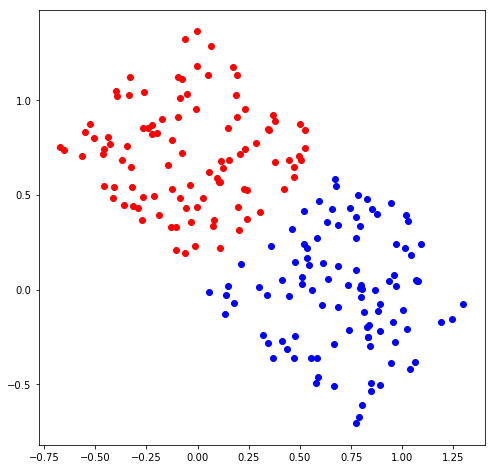

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(X1[:,0],X1[:,1], color='red')
plt.scatter(X2[:,0],X2[:,1], color='blue')

In [5]:
@interact
def _(n_steps=(0,(0..63))):
    # X = (n_points,3)
    # W = (n_points,3)
    n_points = X.shape[0]
    W = np.array([0,0,0])
    P=points(zip(X1[:,0],X1[:,1]),color='blue')
    P+=points(zip(X2[:,0],X2[:,1]),color='red')
    
    k = 0
    max_iter=10000
    j = 0
    while ((k < n_steps) and (j < max_iter)):
        i = j % n_points
        j+=1
        if (X[i,:]@W * yall[i] <= 0):
            W = W + X[i,:]*yall[i]
            P+=points(X[i,:2],color='yellow')
            k+=1
    print(W)
    
    x_left = -2
    x_right = 2
    y_left = 0
    y_right = 0
    if (W[1] != 0):
        y_left = (-W[2] - x_left*W[0])/W[1]
        y_right = (-W[2] - x_right*W[0])/W[1]
    P+=line([(x_left,y_left),(x_right,y_right)])
    
    show(P,xmin=-1,xmax=2,ymin=-1,ymax=2)

Interactive function <function _ at 0x7f9d0b44a8c0> with 1 widget
  n_steps: SelectionSlider(description='n_st…

### Theorem: Perceptron for linearly separable data
> If there exists $w^\ast$ such that $w^\ast \cdot x_i l_i \geq 1$ for all $i$. Then the perceptron algorithm find a $w$ satisfying $w \cdot x_i l_i \geq 0$ for all $i$ in at most $r^2|w^\ast|^2$ updates, where $r = \max_i |x_i|$.

So this theorem guarantees that if the two classes can be separated then the preceptron will also find a separator in finite time.

### Kernels

What about non-linearly separable data. Take for instance
$$
    X = (B_4 \setminus B_3) \cup B_1
$$
and let $c^\ast = B_1$. We cannot separate these sets using a linear classifier

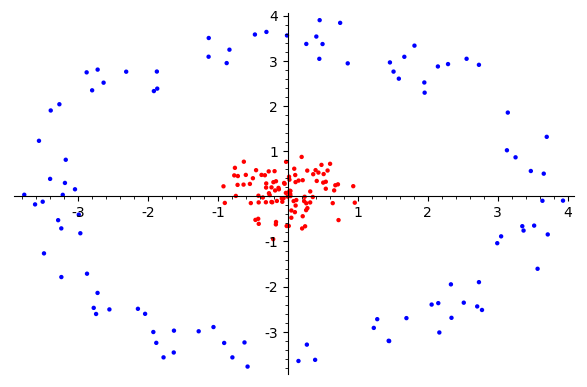

In [6]:
A = np.random.normal(size=(100,2))
A_unit = A/(np.linalg.norm(A,axis=1).reshape(-1,1))
radial_A = 3+np.random.uniform(size=(100,1))
P=points(A_unit*radial_A,color='blue')

B = np.random.normal(size=(100,2))
B_unit = B/(np.linalg.norm(B,axis=1).reshape(-1,1))
radial_B = np.random.uniform(size=(100,1))
P+=points(B_unit*radial_B,color='red')
P.show()

we can however separate the following mapping of $X$. Namely in $\mathbb R^2$ we can do
$$
    \phi(x) = (x_1,x_2,x_1^2+x_2^2) \in \mathbb R^3
$$
This is clearly linearly separable as we can see in the following 3d plot

In [7]:
A_2d = A_unit*radial_A
A_3d = np.concatenate([A_2d,np.linalg.norm(A_2d,axis=1).reshape(-1,1)^2],axis=1)
B_2d = B_unit*radial_B
B_3d = np.concatenate([B_2d,np.linalg.norm(B_2d,axis=1).reshape(-1,1)^2],axis=1)

P=points(A_3d,size=20,color='blue')
P+=points(B_3d,size=20,color='red')
P.show()

Graphics3d Object

So if we transform the $x \to \phi(x)$ for some good transformation $\phi$ then our perceptron will try to solve
$$
    w \cdot \phi(x_i)l_i > 0
$$
furthermore, remember how we constructed $w$ using the perceptron algorithms, i.e. using additions of $x_i l_i$, which transforms into $\phi(x_i)l_i$, and we start with $w=0$, this gives that the weight has the form
$$
    w = \sum_{i=1}^n c_i \phi(x_i)
$$
for numbers $c_i$. The perceptron algorithm becomes just addition and subtraction of certain $c_i$'s by 1.

Furthermore
$$
    w \cdot \phi(x_i) = \sum_{i=1}^n c_j \phi(x_j) \cdot \phi(x_i) = \sum_{i=1}^n c_i k_{ij}
$$
where $k_{ij} = \phi(x_i) \cdot \phi(x_j)$.

Is it easy to find such a mapping $\phi$? No, it is actually quite difficult. Furthermore, if the mapping $\phi$ is high dimensional we might need to do alot of computation, which is not so efficient. What if we had a function $k(x,y)$ that could be written as
$$
    k(x,y) = \phi(x) \cdot \phi(y)
$$
for some $\phi$ and $k$ is easier to compute, then our life would be simpler. Also, what if we are given a function $k(x,y)$ and we would like to know if it is a "kernel function".

### Lemma
If $k_{ij}$ is symmetric and positive semidefinite, then there is a mapping $\phi$ such that
$k_{ij} = \phi(x_i)\phi(x_j)$.

### Proof
1. $k = Q \Lambda Q^T$ (eigendecomposition)
2. $k$ is positive definite, all eigenvalues $\geq 0$, so we can define $B = Q \Lambda^{1/2}$.
3. $k = B B^T$
4. define $\phi(x_i) = B_{i\cdot}$, i.e. the $i$:th row of $B$, then $k_{ij} = \phi(x_i)\cdot \phi(x_j)$.


We now have a way to identify whenever a matrix $k$ is a kernel matrix. There are some standard choices of kernel functions one could try, that produces positive semi-definite matrices whenever all points $x_i$ are distinct.
1. $k(x,y) = e^{-\gamma |x-y|}$, called Radial Basis Function
2. $k(x,y) = (\gamma x \cdot y + r)^d$, polynomial
3. $k(x,y) = x \cdot y$, linear
4. $k(x,y) = \tanh(\gamma x \cdot y + r)$, sigmoidal


### Definition
> We call a function $k(x,y)$ a kernel function if there is a mapping $\phi$ such that $k(x,y) = \phi(x) \cdot \phi(y)$.

### Theorem (properties)
Suppose $k_1,k_2$ are kernel functions. Then
1. For any constant $c \geq 0$, $c k_1$ is a kernel function.
2. For any scalar function $f$, $k(x,y) = f(x)f(y)k_1(x,y)$ is a kernel function.
3. $k_1 + k_2$ is a kernel function.
4. $k_1k_2$ is a kernel function.

## Let me cheat a bit

As we have noted, the perceptron converges in finite time if the set is linearly separable. The way to solve this problem is to introduce a "cost function" that penalizes misses in classification, the goal is then to minimize the total cost. The perceptron becomes the Support Vector Machine in this case, the loss is the so called "hinge loss"
$$
    \min(0,1-w \cdot x_i l_i)
$$
this means that if $w \cdot x_i l_i \geq 1$ (which is the requirement for the perceptron) we have 0 cost, but if we are closer to the plane $w \cdot x = 0$ then there is a cost proportional to 1 - distance.

Consider the problem of differentiating between the following handwritten digits, where $c^\ast$ is the set of digits greater than or equal to 5.

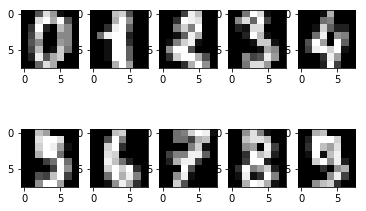

In [28]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
digits = load_digits()
fig, ax = plt.subplots(2,5)
plt.gray()
for i in range(10):
    row = floor(i/5)
    column = i % 5
    ax[row,column].imshow(digits['data'][i,:].reshape(8,8))

In [29]:
from sklearn.svm import SVC

labels = digits['target'] > 5

X = digits['data']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,labels)

per = SVC(kernel='linear')

per.fit(X_train,Y_train)

SVC(kernel='linear')

In [30]:
print("Training precision: \t", per.score(X_train,Y_train))

print("Test precision: \t", per.score(X_test,Y_test))

Training precision: 	 0.9012620638455828
Test precision: 	 0.88


This is really interesting right? With just a linear classifier we can differentiate between digits less than and larger than 5 using a linear classifier up to 88% correct...

But, we talked about the fact that different kernels might improve things. A famous kernel is the Radial Basis Function kernel, which we showed above. Lets try it

### The Radial Basis Function Kernel

In [31]:
from sklearn.svm import SVC

labels = digits['target'] > 5

X = digits['data']

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,labels)

per = SVC(kernel='rbf')

per.fit(X_train,Y_train)

print("Training precision: \t", per.score(X_train,Y_train))

print("Test precision: \t", per.score(X_test,Y_test))

Training precision: 	 0.991833704528582
Test precision: 	 0.9822222222222222


This is borderline crazy, how can we differentiate between these digits at 98% accuracy?
I would leave this up to you to think about. But the fact is that it does work well.

## The underlying problem

Consider a probability space $(\Omega,P,F)$ where $\Omega$ is the sample space and $P$ is the probability measure. In the theory of classifiers we often use the idea that $\Omega$ is split into two parts, one part which corresponds to class  $1$ and one part which corresponds to class $-1$ (or 0). Let us call the subset of $\Omega$ that is labeled as class $1$ the target concept.

> The target concept $c^\ast \subset \Omega$ is the set of outcomes which are labeled $1$, all other are labeled $-1$ (or zero)

Often the sample space $\Omega \subset \mathbb{R}^d$ and as such, each choice of weights $\hat w$ would produce two a split of $\Omega$ into two sets, i.e. the part of $\Omega$ that is one one side of the plane and one which is on the other side of the plane. When we worked with kernel functions we can have a non-linear separating boundary. The point being that we can abstract our idea of a model as being a set.

> A model in our view, i.e. a choice of weights for instance, is the same as a set in $\Omega$, we can denote this set as $h \subset \Omega$.

If $x \in h$ we say that $h$ predicts $x$ as being in $c^\ast$, but it can of-course be wrong. The error we are interested in is the missclassification rate, i.e.

> False positive (FP) $x \in h$ but $x \not \in c^\ast$, and the other which is False Negative (FN) $x \not \in h$ but $x \in c^\ast$. 

The set of miscalssified samples can be written as the symmetric difference of the set $h$ and $c^\ast$, i.e.

$$
    h \Delta c^\ast = (h \setminus c^\ast) \cup (c^\ast \setminus h)
$$

<img src="images/symmetric-difference.jpg"></img>

The true error rate that we are interested in is the probability of a missclassification, i.e.

$$
    P(h \Delta c^\ast) = P(\text{"h classifying x wrongly, i.e. FP or FN"})
$$

This is what we want, but remember that we are taking a training set $S$ and building $h$ on that set. Perhaps  we can find a small training error, which would be

$$
    err(S) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{h \Delta c^\ast}(x_i), \quad S = \{x_1,\ldots,x_n\}
$$

# Understanding model fit and generalization

So far we have only considered quite simple models, we did however touch upon polynomial regression back in `12.ipynb`. The point I want to make here is that we can make the ansatz for the regression function $r(x) = E(Y \mid X=x)$ arbitrarily complicated, think for instance of polynomials of arbitrarily high order.

Let us highlight the problem with a simple example of polynomial regression using `scikit-learn`.

Let us assume that $r(x) = -x^2$ and that $Y \mid X \sim N(r(x),0.1^2)$.

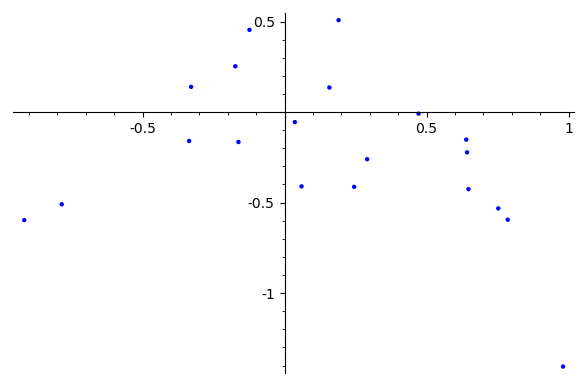

In [8]:
import numpy as np
n_samples = 20
sigma=0.3
np.random.seed(6)
X = np.random.uniform(size=n_samples)*2-1
Y = -X**2 + np.random.normal(size=n_samples)*sigma
points(zip(X,Y))

In [9]:
X

array([ 0.7857203 , -0.33604039,  0.64245825, -0.91660675, -0.78468664,
        0.19010413,  0.05963472, -0.16238514, -0.3291843 ,  0.24503886,
       -0.12371715,  0.47176421,  0.03607282,  0.1577172 ,  0.29071019,
        0.98044854,  0.63971639, -0.17359813,  0.75253531,  0.64751887])

Ok, so our goal is to find the function $r(x)=-x^2$, but we do not now beforehand which power it is, so we have to make an ansatz. Perhaps our ansatz is the either it is linear, second or third order polynomial. Lets try all these and see what happens.

In [10]:
# We will be trying all models on the same training data and hold out some as test-data
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.5)

In [11]:
X_lin_train = X_train.reshape(-1,1)
X_second_train = np.stack([X_train,X_train^2],axis=1)
X_third_train = np.stack([X_train,X_train^2,X_train^3],axis=1)

In [12]:
from sklearn.linear_model import LinearRegression
lr_lin = LinearRegression()
lr_second = LinearRegression()
lr_third = LinearRegression()

lr_lin.fit(X_lin_train,Y_train)
lr_second.fit(X_second_train,Y_train)
lr_third.fit(X_third_train,Y_train)

LinearRegression()

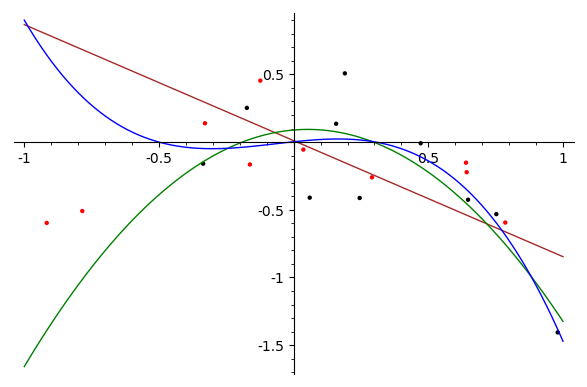

In [104]:
x_plot = np.linspace(-1,1,100).reshape(-1,1)
P = line(zip(x_plot,lr_lin.predict(x_plot)),color='brown')
P+= line(zip(x_plot,lr_second.predict(np.concatenate([x_plot,x_plot^2],axis=1))),color='green')
P+= line(zip(x_plot,lr_third.predict(np.concatenate([x_plot,x_plot^2,x_plot^3],axis=1))),color='blue')
P+= points(zip(X_train,Y_train),color='black')
P+= points(zip(X_test,Y_test),color='red')
show(P)

Since our dataset is not very large, i.e. we had only 10 points and 10 of those we trained on, the estimation problem will be noisy. But what we can tell from the picture above is that the green curve is doing best in terms of the red points which is the test-data. This is called the problem of generalization. Let us formalize this problem as follows

## Formalizing the problem

1. Our training set $S$ consists of points drawn IID from a distribution $D$
2. Our objective is to predict well on new points that are also drawn IID from $D$.

With this statement of the problem it becomes clear that if we can simulate the training-test split, train a model on the training data and test on the testing data, then we can get a measure of the generalization performance of the model itself on the distribution $D$.

## The issue of overfitting and what to do about it?

To analyze overfitting we have to dig into the ideas of learning theory. As such we need some definitions

> A hypothesis class $\mathcal H$ over $\Omega$ is a collection of subsets of $\Omega$, called hypothesises or concepts.

### Example
In the case of a linear classifier we have 
$$\mathcal{H} = \{\{x \in \Omega: w \cdot x \geq 0\}: w \in \mathbb R^d\}.$$
That is, the set of all half-spaces in $\Omega \subset \mathbb R^d$.

### Uniform convergence

The goal of our algorithm can now be stated as the problem of finding an $h \in \mathcal H$ such that the true error is small, i.e. $P(h \Delta c^\ast)$ is small.

The idea for us today is to start with a finite $\mathcal H$, why?

<img src="images/Linear3pts.png"></img>

Three points can always be split in any possible way so for 3 points we have for a linear classifier $|\mathcal H| = 2^3$.

<img width=200px src="images/Linear4pts.png"></img>

For 4 points, we can no longer split every possible combination, for instance the one in the image above cannot be produced. Therefore $|H| < 2^4$. In fact there is a lemma called Sauer-Shelah lemma that states (in our case of linear problems in $\mathbb R^2$)
$$
    |\mathcal H_n| \leq n^3 + 1
$$

So, with this motivation let us continue with finite set of $\mathcal H$.

We start with the theorem 5.4 from the book, but rephrased using our language

### Theorem [Finite hypothesis class]
> Let $(\Omega,P,F)$ be a probability space, and let $\mathcal{H}$ be a finite hypothesis class. Fix $\epsilon > 0$ and let $S = \{X_1,\ldots,X_n\}$ be IID sampled from $P$. Define $\mathcal{H}_\epsilon = \{h \in \mathcal{H}, err(h) \geq \epsilon\}$, then
>$$P(\{\exists h_i \in \mathcal{H}_\epsilon : err_S(h_i) = 0\}) \leq |\mathcal{H}|(1-\epsilon)^n$$
>or equivalently
>$$P(\{err_S(h_i) > 0, \forall h_i \in \mathcal{H}_\epsilon\}) \geq 1-|\mathcal{H}|(1-\epsilon)^n.$$
>If
>$$n \geq \frac{1}{\epsilon}(\ln |\mathcal H| + \ln(1/\delta)) $$
>then
>$$P(\{err_S(h_i) > 0, \forall h_i \in \mathcal{H}_\epsilon\}) \geq 1-\delta$$

In words, for a hypothesis $h$ with large true error, if the training set is large enough there is a high chance that the training set will also contain some missclassified items.

### Proof

The idea is as follows, if we know that $err(h) = P(h \Delta c^\ast) \geq \epsilon$, then define the random variable $Y(X) = \mathbf{1}_{h \Delta c^\ast}(X)$ for $X \sim P$. This r.v. $Y$ is either 1 or 0, and we know that
$$
    P(Y = 1) = P(X \in h\Delta c^\ast) = P(h \Delta c^\ast) \geq \epsilon
$$
thus we know that $Y \sim Bernoulli(\theta)$ where $\theta \geq \epsilon$. We can do the same of the entire sample $S$, and define a $Y_i$ for all $X_i$, and note that since $X_i$ is IID, then $Y_i$ is IID, and thus
$$
    P(err_S(h) = 0) = P(\{Y_i = 0: \forall i = 1,\ldots,n\}) = P(Y_1 = 0)^n \leq (1-\epsilon)^n.
$$
That is we can now do the following bound
$$
    P(\cup_{h \in \mathcal{H_\epsilon}} \{err_S(h) = 0\}) \leq \sum_{h \in \mathcal{H_\epsilon}}P(err_S(h) = 0) \leq |\mathcal{H}_\epsilon|(1-\epsilon)^n \leq |\mathcal{H}|(1-\epsilon)^n
$$
This proves the first statements, the second follow from taking the complement of the first. The last statement follows from plugging in the bound for $n$ and doing some simple estimation (See book).

Say that we had a way of finding for each $S$ a $h_S$ such that $err(h_S) = 0$, for each $S$? Think of the perceptron for instance.

In [8]:
(1/0.1)*(np.log(1000)+np.log(1/0.01))

115.12925464970229

Then we can say that
$$P(err(h_S) > \epsilon) \leq P(\{\exists h_i \in \mathcal{H}_\epsilon : err_S(h_i) = 0\})$$
Note that in the above we have inequality because the event $\{err(h_S) > \epsilon\} \subset \{\exists h_i \in \mathcal{H}_\epsilon : err_S(h_i) = 0\}$. The conclusion is that

### Theorem [PAC Learnability of Empirical Risk Minimization]
> Let $(\Omega,P,F)$ be a probability space, and let $\mathcal{H}$ be a finite hypothesis class. Fix $\epsilon > 0$ and let $S = \{X_1,\ldots,X_n\}$ be IID sampled from $P$. Further assume that we have a way to construct $h_S \in \mathcal{H}$ such that $err_S(h_S) = 0$, then
>$$P(err(e_S) > \epsilon) \leq |\mathcal{H}|(1-\epsilon)^n.$$
>Again if 
>$$n \geq \frac{1}{\epsilon}(\ln |\mathcal H| + \ln(1/\delta)) $$
>then
>$$P(err(h_S) < \epsilon) \geq 1-\delta$$

That is with high probability the method which minimizes the training error has good true error. This ofcourse assumes that there is $h \in \mathcal{H}$ such that $err(h) = 0$. Which is not always the case, take the example of a curved decision boundary, and our hypothesis space consists of linear boundaries. This can happen if our kernel choice is not correct concerning the true $c^\ast$. In that case, the above argument does not work and we have to use other tools.？

### Theorem (Hoeffding bounds)
>Let $X_1,\ldots, X_n$ be IID Bernoulli$(\theta)$ r.v.. Let $\overline{X}_n = \sum_{i=1}^n X_i$. Now for any $0 \leq \alpha \leq 1$
>$$P(\overline{X}_n > \theta+\alpha) \leq e^{-2n\alpha^2} $$
>$$P(\overline{X}_n < \theta-\alpha) \leq e^{-2n\alpha^2} $$

We will not prove this now, but using this we can get the following result concerning uniform convergence of the error.

### Theorem (Uniform convergence)
> Let $(\Omega,P,F)$ be a probability space, and let $\mathcal{H}$ be a finite hypothesis class. Fix $\epsilon > 0$ and let $S = \{X_1,\ldots,X_n\}$ be IID sampled from $P$. Then
> $$P(\{|err(h) - err_S(h)| \leq \epsilon, \forall h \in \mathcal{H}\}) > 1-2|\mathcal{H}|e^{-2n\epsilon^2}$$

>This tells us that the convergence in probability has a uniform rate!!!

In [32]:
1/(2*0.1**2) * (np.log(1000)+np.log(2/0.01))

610.3036322765087

In [7]:
import numpy as np
m = np.log(2*1000)-np.log(0.01)
n = 2 * (0.1**2)
m/n

610.3036322765086

### Proof
Fix the hypothesis $h \in \mathcal{H}$, define $Y_i$ as in the proof of `Finite hypothesis class`, then $Y_i \sim$ Bernoulli$(\theta)$ and $\theta = err(h)$, is one if $h$ makes a mistake and $0$ if not. For a single hypothesis we thus have $err_S(h) = \overline{Y}_n$ and using the Hoeffding bound gives us
$$
    P(\overline{Y_n} > err(h) + \epsilon) \leq e^{-2n\epsilon^2}
$$
$$
    P(\overline{Y_n} > err(h) - \epsilon) \leq e^{-2n\epsilon^2}
$$
i.e.
$$
    P(|err_S(h) - err(h)| > \epsilon) \leq 2 e^{-2n\epsilon^2}
$$
since this holds for a single hypothesis we can again use the union bound to get
$$
    P(\{|err_S(h) - err(h)| > \epsilon, \exists h \in \mathcal{H}) \leq 2 |\mathcal{H}| e^{-2n\epsilon^2}
$$
taking the complement event we get the result of our theorem.

---
## Assignment 4, PROBLEM 2
Maximum Points = 1


Consider an instance space $X$ consisting of integers $1$ to $1000$ and a target concept $c^\ast = \{x: 501 \leq x \leq 1000\}$. If your hypothesis class $\mathcal H$ is $\{h_j:\, h_j=\{x: j \leq x \leq 1000\}, j=1,\ldots,1000\}$. How large must the training set $S$ be to ensure that with probability $99\%$ any consistent hypothesis (training error 0) will have a true error less than $10\%$. (Hint: use the theorem above).

In [ ]:
# Replace the XXX below with the number of training samples needed to satisfy the problem
N = 611

---
#### Local Test for Assignment 4, PROBLEM 2
Evaluate cell below to make sure your answer is valid.                         You **should not** modify anything in the cell below when evaluating it to do a local test of                         your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [4]:
# test that your answer is indeed a number by evaluating this cell after you replaced XXX above and evaluated it.
try:
    assert((type(N) is Integer) or (type(N) is int))
    print("Your answer is an integer, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing an integer of class Integer or int")

Your answer is an integer, hopefully it is correct.


---
## Assignment 4, PROBLEM 3
Maximum Points = 3


The following datasets are subsets of $d$-dimensional '0/1' vectors with label +1. The remaining '0/1' vectors are '-1'. Determine if the following three problems are linearly separable:

1. $c^\ast = \{(0,1,0),(0,1,1),(1,0,0),(1,1,1)\}$, and $X$ is all $0/1$ vectors in 3 dimensions.
2. $c^\ast = \{(0,1,1),(0,1,0),(1,1,0),(1,1,1)\}$, and $X$ is all $0/1$ vectors in 3 dimensions.
3. $$\begin{align*}
      c^\ast = \{(0,1,0,0),(0,1,0,1),(0,1,1,0),(1,0,0,0)\\
      ,(1,1,0,0),(1,1,0,1),(1,1,1,0),(1,1,1,1)\}
    \end{align*}$$
    and $X$ is all $0/1$ vectors in 4 dimensions.

In [13]:
# Replace XXX, YYY, ZZZ with True if true and False if false, they represent the three problems
Solution_Q1 = False
Solution_Q2 = True
Solution_Q3 = True

---
#### Local Test for Assignment 4, PROBLEM 3
Evaluate cell below to make sure your answer is valid.                         You **should not** modify anything in the cell below when evaluating it to do a local test of                         your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [14]:
# test that your answer is indeed booleans by evaluating this cell after you replaced XXX, YYY, ZZZ above and evaluated it.
try:
    assert(type(Solution_Q1) is bool)
    print("Your answer Q1 is a boolean, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing a boolean (True or False)")
try:
    assert(type(Solution_Q2) is bool)
    print("Your answer Q2 is a boolean, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing a boolean (True or False)")
try:
    assert(type(Solution_Q3) is bool)
    print("Your answer Q3 is a boolean, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing a boolean (True or False)")

Your answer Q1 is a boolean, hopefully it is correct.
Your answer Q2 is a boolean, hopefully it is correct.
Your answer Q3 is a boolean, hopefully it is correct.


### The case of infinite hypothesis spaces

How do we generalize this to infinite hypothesis classes?

The first thing we are going to do is to define data dependent equivalence classes.

We start with a symmetrization lemma by Vapnik and Chervonenkis, in the book you can find this hidden in the proof of Theorem 5.14.

**Symmetrization Lemma (Vapnik, Chervonenkis, 1971):** Let $D$ and $D'$ be two different sample data-sets from $\mu$ then for $n \epsilon^2 \geq 2$
$$\begin{multline}
    \mathbb{P}\left[\sup_{h \in \mathcal{H}}\left|err(h) - err_D(h)\right| > \epsilon\right] 
    \leq 2\mathbb{P}\left[\sup_{h \in \mathcal{H}}\left|err_D(h) - err_{D'}(h)\right| > \frac{\epsilon}{2}\right]
\end{multline}
$$

* Define data-dependent equivalence classes on $\mathcal{H}$ with respect to $D$
$$h_1 = h_2, \iff h_1(x) = h_2(x), \forall (x,.) \in D$$
i.e. they produce the same labels.
* The set of classes is denoted $\mathcal{H}_D$, note that $|\mathcal{H}_D| < \infty$.

Now by the union bound we get
$$
\begin{multline}
    \mathbb{P}\left[\sup_{h \in \mathcal{H}_{D\cup D'}}\left|err_D(h) - err_{D'}(h)\right|>\frac{\epsilon}{2}\right] 
    \leq s(\mathcal{H},N) \sup_{h \in \mathcal{H}} \mathbb{P}\left[\left|err_D(h) - err_{D'}(h)\right|>\frac{\epsilon}{2}\right]
\end{multline}
$$
where $s(\mathcal{H},N)$ is an upper bound on $|\mathcal{H}_{D \cup D'}|$, called $\pi_{\mathcal H}(n)$ in the book.

# Growth function (shattering number)

The largest size of $\mathcal{H}_D$ for a given $N$ is called the shattering number for $\mathcal{H}$ given $N$
$$s(\mathcal{H},N) = \sup_{x_1,\ldots, x_N} |\mathcal{H}_{\{x_1,\ldots,x_N\}}|$$
> **Note:** this is a combinatorial number and does not depend on $\mu$. 

# Can we bound $s(\mathcal{H},N)$?

* If we knew nothing then the best we can do is (binary classification)
$$s(\mathcal{H},N) \leq 2^N$$
Remember: Hoeffdings inequality gave a decay of $\exp(-2N\epsilon^2)$. **Too weak**

* This is where **VC**(Vapnik Chervonenkis)-dimension comes in!

# Vapnik Chervonenkis dimension
**Def:** We say that $\mathcal{H}$ **shatters** a set $D = \{x_i,i=1,\ldots, N\}$ for any disjoint split $D_1,D_{-1}$ of $D$ we can find $h \in \mathcal{H}$ such that $h(D_1) = 1$, $h(D_{-1})=-1$.

**Def:** The VC-dimension of $\mathcal{H}$, denoted by $\text{VC-dim}(\mathcal{H})$ , equals the largest integer $n$ such that there exists a set of cardinality $n$ that is shattered by $\mathcal{H}$.

# Sauer–Shelah lemma (1972)
Let $k = \text{VC-dim}(\mathcal{H})$ then for $N > 0$ we have
$$
    s(\mathcal{H},N) \leq \sum_{i=0}^{k-1} {N \choose i}
$$

* Independently proved by Sauer and Shelah in 1972
* Actually proved slightly before by Vapnik and Chervonenkis (1971?)

This is polynomial:
$$s(\mathcal{H},N) \leq \left ( \frac{Ne}{k}\right )^k $$

Proof: Let $\lambda \in (0,1)$ then
$$
\begin{align}
    1 &= (\lambda + (1-\lambda))^N \\
    &\geq \sum_{i=1}^{\lambda N} {N \choose i} \lambda^i(1-\lambda)^{n-1} \\
    &\geq \sum_{i=1}^{\lambda N} {N \choose i} \left (\frac{\lambda}{1-\lambda} \right )^{\lambda n} (1-\lambda)^n
\end{align}
$$
Thus
$$
\begin{align}
    \sum_{i=1}^{\lambda N} {N \choose i} &\leq e^{N((\lambda-1)\log(1-\lambda)-\lambda \log(1-\lambda))} \\
    &\leq e^{N(\lambda-\lambda \log(1-\lambda))} \\
    &= \left ( \frac{e N}{\lambda N} \right )^{\lambda N}
\end{align}
$$
Then for $k = \lambda N$ we have our result.

# Putting it all together

$$
\begin{align}
    \mathbb{P}&\left[\sup_{h \in \mathcal{H}}\left|err(h) - err_{D}(h)\right| > \epsilon\right] \\
    &\leq 2\mathbb{P}\left[\sup_{h \in \mathcal{H}}\left|err_{D}(h) - err_{D'}(h)\right| > \frac{\epsilon}{2}\right] \quad \text{(Symmetrization Lemma)}\\
    &\leq 2 s(\mathcal{H},2 N) \sup_{h \in \mathcal{H}}  \mathbb{P}\left[\left|err_{D}(h) - err_{D'}(h)\right|>\frac{\epsilon}{2}\right] \text{(Shattering number + Classes)}\\
    &\leq 2 s(\mathcal{H},2 N) \sup_{h \in \mathcal{H}}   \left ( \mathbb{P}\left[\left|err(h) - err_{D}(h)\right|>\frac{\epsilon}{4}\right] + \mathbb{P}\left[\left|err(h) - err_{D'}(h)\right|>\frac{\epsilon}{4}\right] \right ) \\
    &\leq 8 s(\mathcal{H}, 2N)\exp \left (-\frac{N\epsilon^2}{8} \right ) \quad \text{(Hoeffdings Inequality)} 
\end{align}
$$

Finally we have proved the VC inequality

# VC inequality (1971)

$$
\begin{multline}
    \mathbb{P}\left[\sup_{h \in \mathcal{H}}\left|err(h) - err_D(h)\right| > \epsilon\right] 
    \leq 8 s(\mathcal{H},2N) \exp \left (-\frac{N\epsilon^2}{8} \right )
\end{multline}
$$

Choosing the values of $\epsilon$ wisely we can get

# VC generalization bound
Thus we can for any $\delta$ find that with probability $(1-\delta)$ the following estimate holds

$$
    err(h) \leq err_{D} + \sqrt{\frac{8 \ln(s(\mathcal{H},2N))+8\ln\frac{8}{\delta}}{N}}
$$

for any $h \in \mathcal{H}$.

Using the bound on the growth function when we have a fixed VC dimension, the above bound becomes

# VC generalization bound
We can for any $\delta$ find that with probability $(1-\delta)$ the following estimate holds
$k = \text{VC-dim}(\mathcal{H})$
$$
    err(h) \leq err_{D} + \sqrt{\frac{8 k\ln\left ( \frac{2Ne}{k}\right )+8\ln\frac{8}{\delta}}{N}}
$$
We need $k \lesssim N$ in order for the estimate to be useful.

We can plot how many data-points are needed just to make the quantity on the right hand side less than $1$.

0.0

In [25]:
?fsolve

/Users/mac/opt/miniconda3/envs/sage/lib/python3.7/site-packages/sphinx/util/nodes.py:94: FutureWarning: 
   The iterable returned by Node.traverse()
   will become an iterator instead of a list in Docutils > 0.16.
  for classifier in reversed(node.parent.traverse(nodes.classifier)):


In [31]:
from scipy.optimize import fsolve
import numpy as np
import matplotlib.pyplot as plt

def find_N(k=1,prec=0.1):
    delta=0.01
    c = 8*k
    t = 8*k*np.log(1)+8*np.log(8/delta)
    func = lambda x: t+c*np.log(x)-prec*x
    x_init = k*1000
    return fsolve(func,x_init)

k = np.arange(1,100)
N = np.array([find_N(k0,0.1^2) for k0 in k]).ravel()
print(N[0])

print(find_N(1,0.1^2))
def plot_numreq():
    plt.figure(figsize=(7,7))
    plt.plot(k,N)
    plt.xlabel("VC-dimension = $k$")
    plt.ylabel("Datapoints required = $N$")
    plt.title("$\\frac{8 k\\ln\\left ( \\frac{2Ne}{k}\\right )+8\\ln\\frac{8}{\\delta}}{N} = 1, \\delta = 0.1$",fontsize=15,pad=10)
    plt.show()



12920.975184677054
[12920.97518468]


The above implies that for a model that has many parameters, we need a vast amount of data-points. Thus theoretical guarantees are quite lax.

---
## Assignment 4, PROBLEM 4
Maximum Points = 1


In Problem 1 we looked at the following problem:
Consider an instance space $X$ consisting of integers $1$ to $1000$ and a target concept $c^\ast = \{x: 501 \leq x \leq 1000\}$. If your hypothesis class $\mathcal H$ is $\{h_j:\, h_j=\{x: j \leq x \leq 1000\}, j=1,\ldots,1000\}$. 

What is the VC-dimension of our hypothesis class? That is, what is the maximum number of points such that $\mathcal H$ shatters that set?

In [ ]:
# Replace XXX with the VC dimension
VC_dimension = 1

---
#### Local Test for Assignment 4, PROBLEM 4
Evaluate cell below to make sure your answer is valid.                         You **should not** modify anything in the cell below when evaluating it to do a local test of                         your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [14]:
# test that your answer is indeed a number by evaluating this cell after you replaced XXX above and evaluated it.

try:
    assert((type(VC_dimension) is Integer) or (type(VC_dimension) is int))
    print("Your answer is an integer, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing an integer of class Integer or int")

Your answer is an integer, hopefully it is correct.


---
## Assignment 4, PROBLEM 5
Maximum Points = 1


Revisit problem 1 using the VC_dimension that you used in Problem 3, by instead applying the VC-bound.
Consider an instance space $X$ consisting of integers $1$ to $1000$ and a target concept $c^\ast = \{x: 501 \leq x \leq 1000\}$. If your hypothesis class $\mathcal H$ is $\{h_j:\, h_j=\{x: j \leq x \leq 1000\}, j=1,\ldots,1000\}$. How large must the training set $S$ be to ensure that with probability $99\%$ any consistent hypothesis (training error 0) will have a true error less than $10\%$.

In [16]:
# Replace the XXX below with the number of training samples needed to satisfy the problem
N5 = 105

NameError: name 'XXX' is not defined

---
#### Local Test for Assignment 4, PROBLEM 5
Evaluate cell below to make sure your answer is valid.                         You **should not** modify anything in the cell below when evaluating it to do a local test of                         your solution.
You may need to include and evaluate code snippets from lecture notebooks in cells above to make the local test work correctly sometimes (see error messages for clues). This is meant to help you become efficient at recalling materials covered in lectures that relate to this problem. Such local tests will generally not be available in the exam.

In [18]:
# test that your answer is indeed a number by evaluating this cell after you replaced XXX above and evaluated it.
try:
    assert((type(N) is Integer) or (type(N) is int))
    print("Your answer is an integer, hopefully it is correct.")
except AssertionError:
    print("Try again! and make sure you are producing an integer of class Integer or int")

Your answer is an integer, hopefully it is correct.
